# Data Story Telling:  Denver Traffic Accidents and Fatalities
##  What factors influence traffic crashes and deaths?


#  Step 1:  Import 

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from tabulate import tabulate

# Step 2:  Get Data and Do Some Cleaning

## The data for this analysis was publicly available information on the City of Denver website. 

https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents

In [2]:
traffic_accidents = pd.read_csv('traffic_accidents.csv')

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
traffic_accidents2 = traffic_accidents.drop(columns = ['shape', 'incident_id', 'offense_code', 'offense_code_extension', 'first_occurrence_date', 'last_occurrence_date', 'geo_x', 'geo_y', 'geo_lon', 'geo_lat', 'district_id', 'POINT_X', 'POINT_Y'])

In [4]:
traffic_accidents2['FATALITIES'][traffic_accidents2['top_traffic_accident_offense'] == 'TRAF - ACCIDENT - FATAL       '].fillna(1, inplace = True)

In [5]:
fatal_accidents = traffic_accidents2[traffic_accidents2['top_traffic_accident_offense'] == 'TRAF - ACCIDENT - FATAL       ']

In [6]:
traffic_accidents2['top_traffic_accident_offense'].value_counts()

TRAF - ACCIDENT                   142605
TRAF - ACCIDENT - HIT & RUN        59754
TRAF - ACCIDENT - DUI/DUID          5920
TRAF - ACCIDENT - SBI               3114
TRAF - ACCIDENT - POLICE            1988
TRAF - ACCIDENT - FATAL              543
Name: top_traffic_accident_offense, dtype: int64

#  Step 3:  A Look Into Our Data Set


In [7]:
traffic_accidents2.columns

Index(['offense_id', 'top_traffic_accident_offense', 'reported_date',
       'incident_address', 'precinct_id', 'neighborhood_id', 'bicycle_ind',
       'pedestrian_ind', 'HARMFUL_EVENT_SEQ_1', 'HARMFUL_EVENT_SEQ_2',
       'HARMFUL_EVENT_SEQ_3', 'road_location', 'ROAD_DESCRIPTION',
       'ROAD_CONTOUR', 'ROAD_CONDITION', 'LIGHT_CONDITION', 'TU1_VEHICLE_TYPE',
       'TU1_TRAVEL_DIRECTION', 'TU1_VEHICLE_MOVEMENT', 'TU1_DRIVER_ACTION',
       'TU1_DRIVER_HUMANCONTRIBFACTOR', 'TU1_PEDESTRIAN_ACTION',
       'TU2_VEHICLE_TYPE', 'TU2_TRAVEL_DIRECTION', 'TU2_VEHICLE_MOVEMENT',
       'TU2_DRIVER_ACTION', 'TU2_DRIVER_HUMANCONTRIBFACTOR',
       'TU2_PEDESTRIAN_ACTION', 'SERIOUSLY_INJURED', 'FATALITIES',
       'FATALITY_MODE_1', 'FATALITY_MODE_2', 'SERIOUSLY_INJURED_MODE_1',
       'SERIOUSLY_INJURED_MODE_2'],
      dtype='object')

In [8]:
traffic_accidents2['reported_date'].sort_values(ascending = False).head(3)

205270    2022-06-21 22:26:00
209972    2022-06-21 19:28:00
209949    2022-06-21 19:07:00
Name: reported_date, dtype: object

In [9]:
traffic_accidents2['offense_id'].count()

213925

## There are a total of 213,925 accidents reported.  This spans the time-frame of January 1, 2013 through June 21, 2022

In [10]:
fatal_accidents = traffic_accidents2[traffic_accidents2['FATALITIES'] > 0]

In [11]:
fatal_accidents['offense_id'].count()

481

In [12]:
fatal_accidents['FATALITIES'].sum()

503.0

### During this time-frame there were 481 fatal accidents resulting in 503 deaths. 

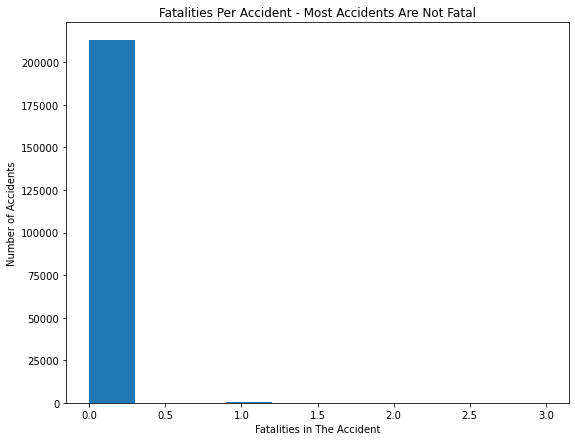

In [13]:
# The majority of traffic accidents are not fatal
plt.rcParams.update({'figure.figsize': (9, 7.0)})
plt.hist(traffic_accidents2['FATALITIES'])
plt.xlabel("Fatalities in The Accident")
plt.ylabel("Number of Accidents")
plt.title("Fatalities Per Accident - Most Accidents Are Not Fatal")
plt.show()

###  The majority of traffic accidents were not fatal

#  Step 4:  What Roadway conditions impact Accidents?

Text(0.5, 1.0, 'Is Light A Factor Total Accidents')

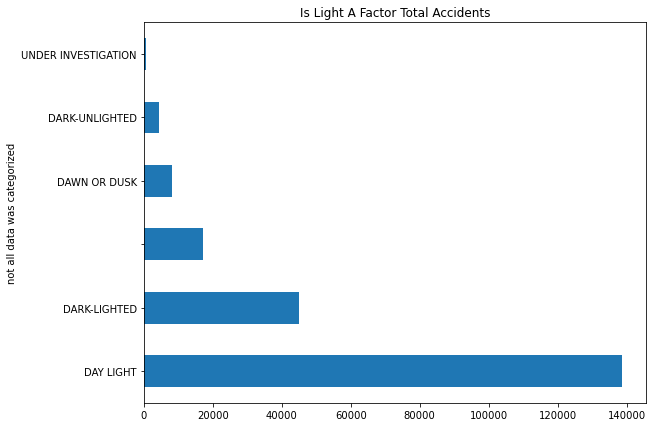

In [14]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
traffic_accidents2['LIGHT_CONDITION'].value_counts().plot(kind='barh')
plt.ylabel("not all data was categorized")
plt.title('Is Light A Factor Total Accidents')

Text(0.5, 1.0, 'Is Light A Factor FATAL Accidents')

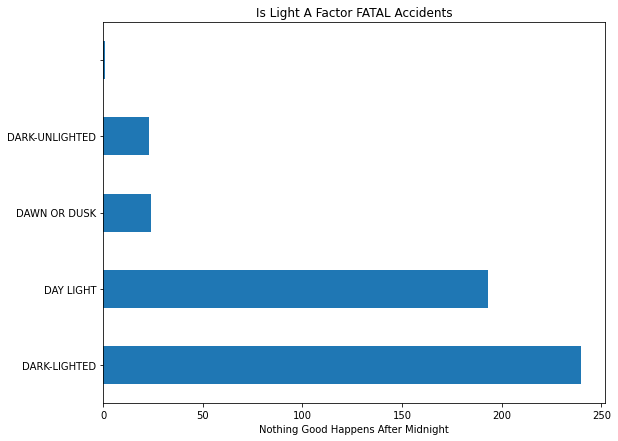

In [15]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
fatal_accidents['LIGHT_CONDITION'].value_counts().plot(kind='barh')
plt.xlabel('Nothing Good Happens After Midnight')
plt.title('Is Light A Factor FATAL Accidents')

## Wow.  It looks like while most accidents happen during the daylight.  Most FATAL accidents occur after DARK.  Be extra careful driving/ biking/ walking after DARK. 

Text(0.5, 1.0, 'Human Cause of Accident')

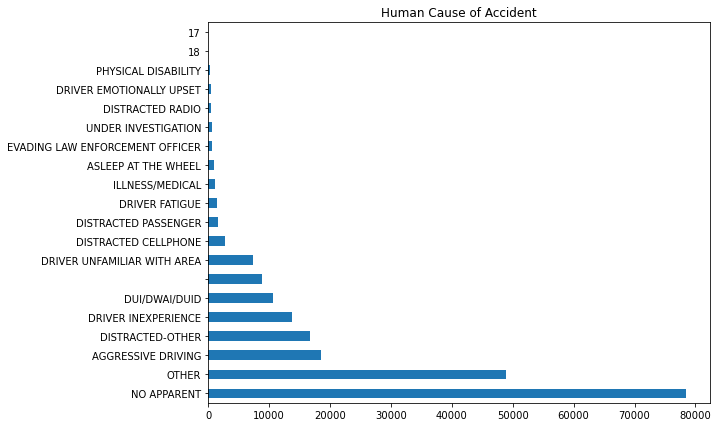

In [16]:
traffic_accidents2['TU1_DRIVER_HUMANCONTRIBFACTOR'].value_counts().plot(kind = 'barh')
plt.title('Human Cause of Accident')

Text(0.5, 1.0, 'Human Cause of Fatal Accident')

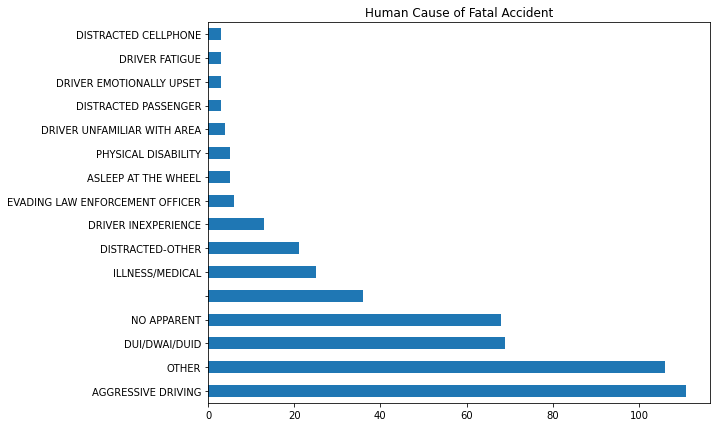

In [17]:
fatal_accidents['TU1_DRIVER_HUMANCONTRIBFACTOR'].value_counts().plot(kind = 'barh')
plt.title('Human Cause of Fatal Accident')

### Number 1 Human Cause of Fatal Accidents is Aggressive Driving.  Just chill out guys!

### Number 3 Human Cause of Fatal Accidents is DUI (drug or alcohol driving) so stay sober when you are driving!

###  Recommendation is to chill out and dont drive when drinking or taking drugs. 

In [18]:
#traffic_accidents2['TU1_DRIVER_ACTION'].value_counts().plot(kind = 'barh')
#plt.title("total accidents")

In [19]:
#fatal_accidents['TU1_DRIVER_ACTION'].value_counts().plot(kind = 'barh')

###  Careless Driving and Reckless Driving seem to play a part in many Fatal Accidents

#  Step 5:  Roadway Conditions

Text(0.5, 1.0, 'Is SNOW A Factor Total Accidents')

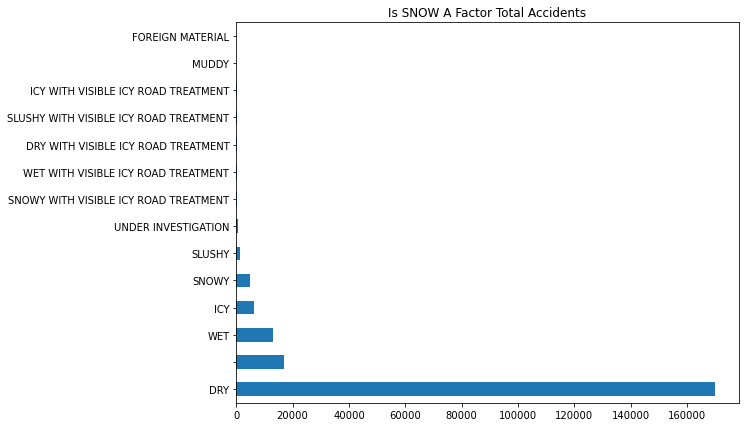

In [20]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
traffic_accidents2['ROAD_CONDITION'].value_counts().plot(kind='barh')
plt.title('Is SNOW A Factor Total Accidents')

Text(0.5, 1.0, 'Is SNOW A Factor Fatal Accidents')

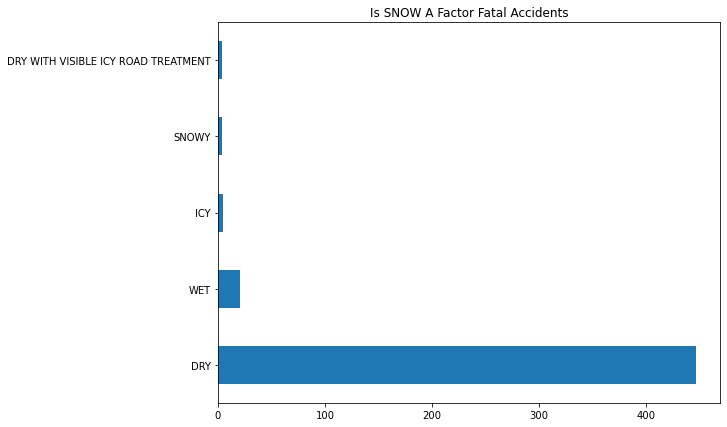

In [21]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
fatal_accidents['ROAD_CONDITION'].value_counts().plot(kind='barh')
plt.title('Is SNOW A Factor Fatal Accidents')

## hmm...perhaps Coloradoans really can drive in the snow.

# Step 6:  Do Traffic Accidents Vary by Month?  Year?

In [22]:
traffic_accidents2['reported_date'] = pd.to_datetime(traffic_accidents2['reported_date'])
fatal_accidents['reported_date'] = pd.to_datetime(fatal_accidents['reported_date'])

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_9328/3150605238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatal_accidents['reported_date'] = pd.to_datetime(fatal_accidents['reported_date'])


In [23]:
traffic_accidents2['month'] = pd.DatetimeIndex(traffic_accidents2['reported_date']).month
fatal_accidents['month'] = pd.DatetimeIndex(fatal_accidents['reported_date']).month
traffic_accidents2['year'] = pd.DatetimeIndex(traffic_accidents2['reported_date']).year
fatal_accidents['year'] = pd.DatetimeIndex(fatal_accidents['reported_date']).year


C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_9328/1794630438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatal_accidents['month'] = pd.DatetimeIndex(fatal_accidents['reported_date']).month
C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_9328/1794630438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatal_accidents['year'] = pd.DatetimeIndex(fatal_accidents['reported_date']).year


Text(0.5, 1.0, 'Which Month has most accidents')

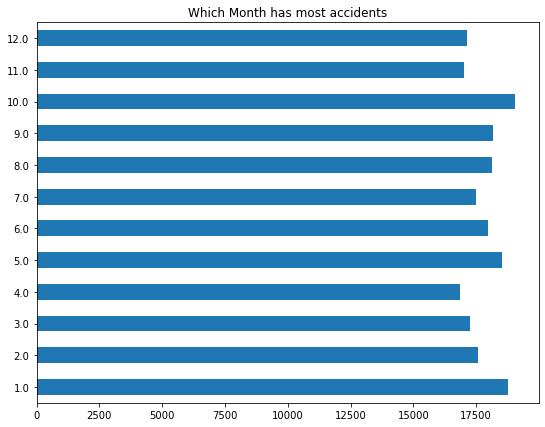

In [24]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
traffic_accidents2['month'].value_counts().sort_index().plot(kind='barh')
plt.title('Which Month has most accidents')

Text(0.5, 1.0, 'Which Month has most FATAL accidents')

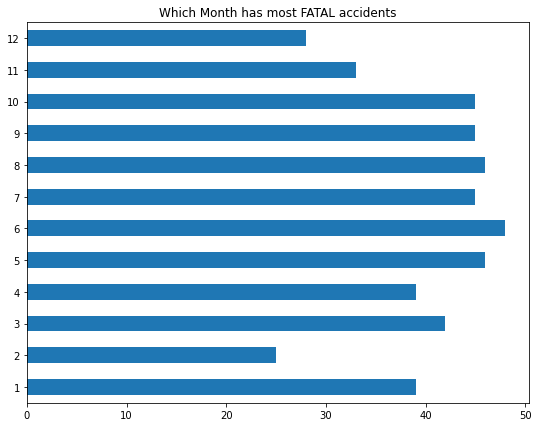

In [25]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
fatal_accidents['month'].value_counts().sort_index().plot(kind='barh')
plt.title('Which Month has most FATAL accidents')

## Number of traffic accidents remain consistent through the year but traffic FATALITIES peak during the warmer months. 

Text(0.5, 1.0, 'Are Traffic Accidents Becoming More Common?')

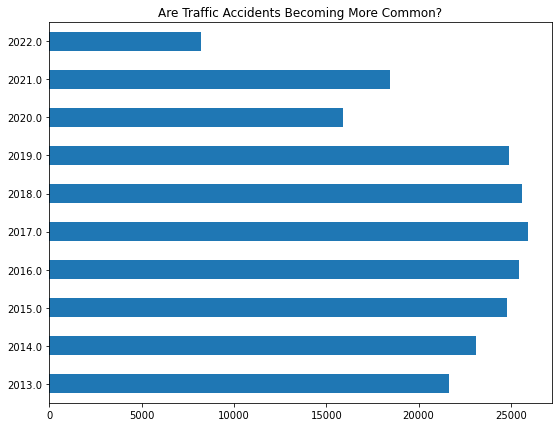

In [26]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
traffic_accidents2['year'].value_counts().sort_index().plot(kind='barh')
plt.title('Are Traffic Accidents Becoming More Common?')

##  Traffic Accidents DECLINED dramatically during 2020 but rebounded in 2021.  Unfortunately 2021 saw the highest number of traffic FATALITIES in recent history!

Text(0.5, 1.0, 'Are FATAL Accidents Becoming More Common?')

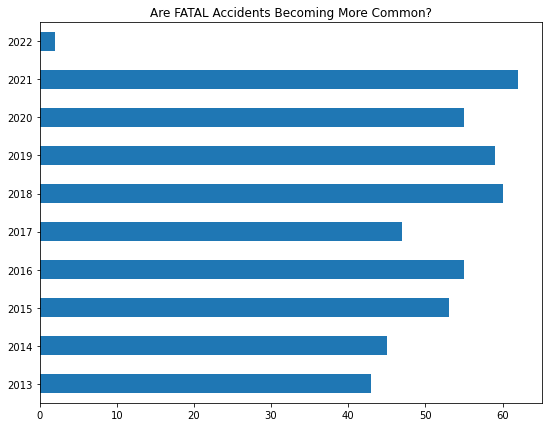

In [27]:
plt.rcParams.update({'figure.figsize': (9, 7.0)})
fatal_accidents['year'].value_counts().sort_index().plot(kind='barh')
plt.title('Are FATAL Accidents Becoming More Common?')

# Step 7:  WHERE do traffic accidents and Fatalities occur? 

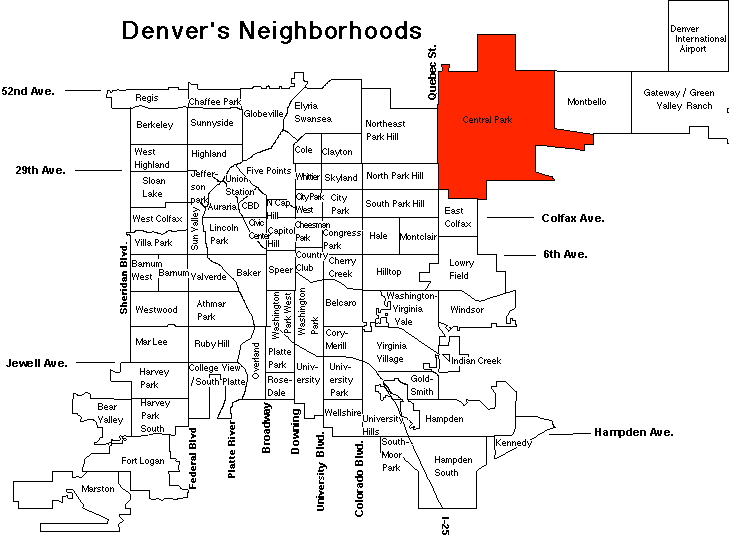

In [28]:
from PIL import Image, ImageSequence

im = Image.open("Denver_Neighborhoods.gif")
im


Text(0.5, 1.0, 'Total Number of Accidents by Neighborhood')

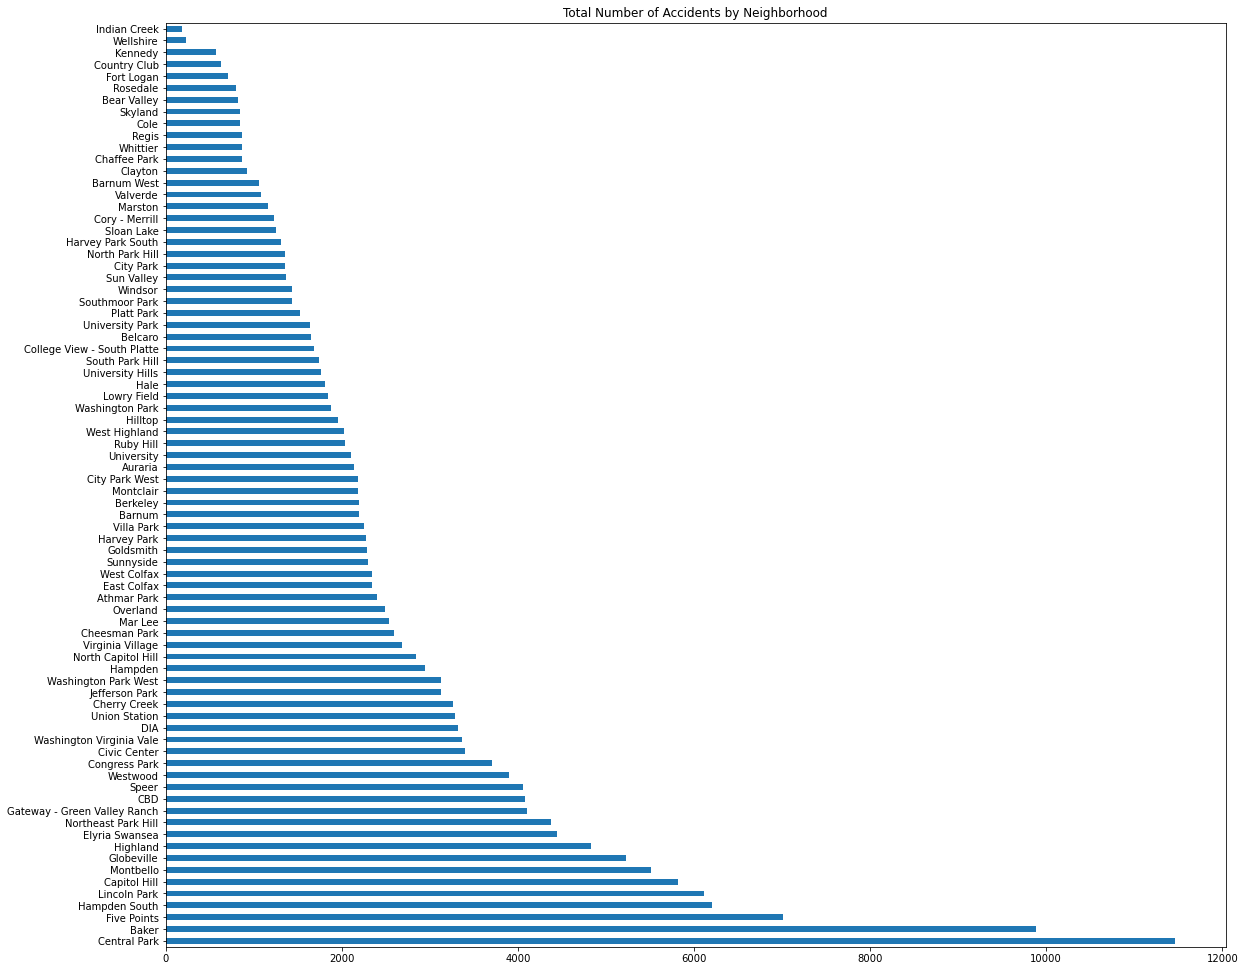

In [29]:
plt.rcParams.update({'figure.figsize': (19, 17.0)})
traffic_accidents2['neighborhood_id'].value_counts().plot(kind='barh')
plt.title('Total Number of Accidents by Neighborhood')

#  YIKES.  When looking at traffic accidents, my own neighborhood of Central Park Looks horrible on this Metric 

### Lets look at Fatal Accidents by neighborhood

Text(0.5, 1.0, 'Total Number of FATAL Accidents by Neighborhood')

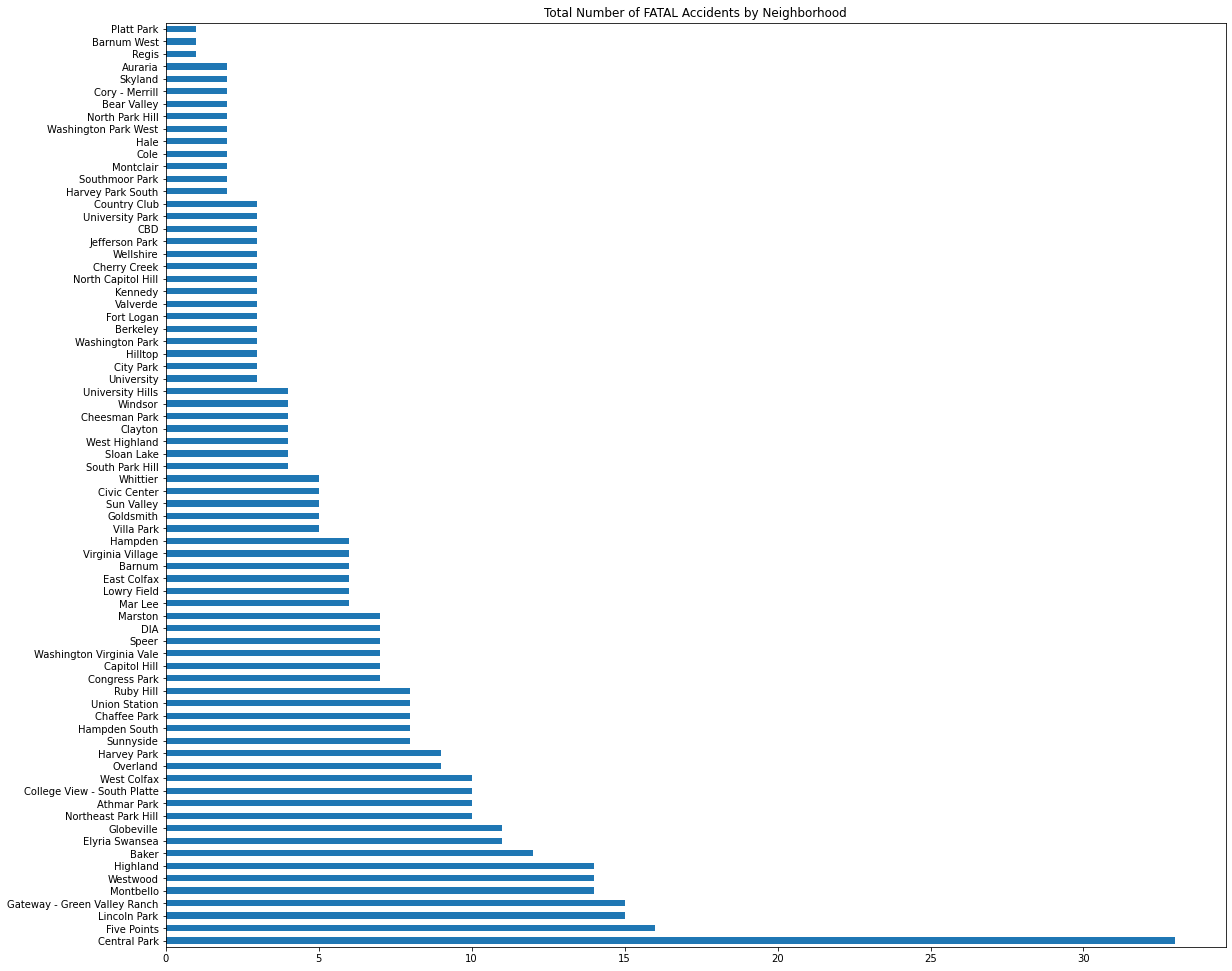

In [30]:
plt.rcParams.update({'figure.figsize': (19, 17.0)})
fatal_accidents['neighborhood_id'].value_counts().plot(kind='barh')
plt.title('Total Number of FATAL Accidents by Neighborhood')

#  Seriously, what is up with Central Park? :  It is a clear outlier in both traffic accidents and traffic deaths.  I must  know ...this is my neighborhood!!!


### Central Park had the highest number of traffic deaths and traffic accidents...lets zoom in to see what is going on with my neighborhood

Text(0.5, 1.0, 'Where in Central Park are ALL of these accidents Happening')

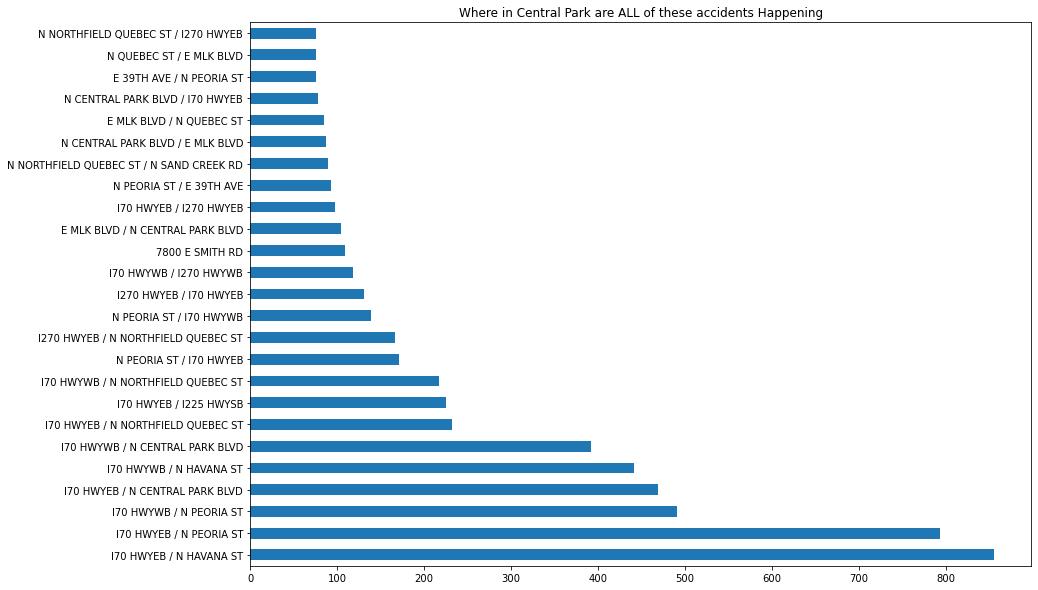

In [31]:
plt.rcParams.update({'figure.figsize': (14, 10.0)})
traffic_accidents2['incident_address'][traffic_accidents2['neighborhood_id'] == 'Central Park'].value_counts()[:25].plot(kind='barh')
plt.title('Where in Central Park are ALL of these accidents Happening')

##  The top 14 addresses for traffic accidents in Central Park are on the HIGHWAY  (I-70)

Text(0.5, 1.0, 'Where in Central Park are ALL of the FATAL accidents Happening')

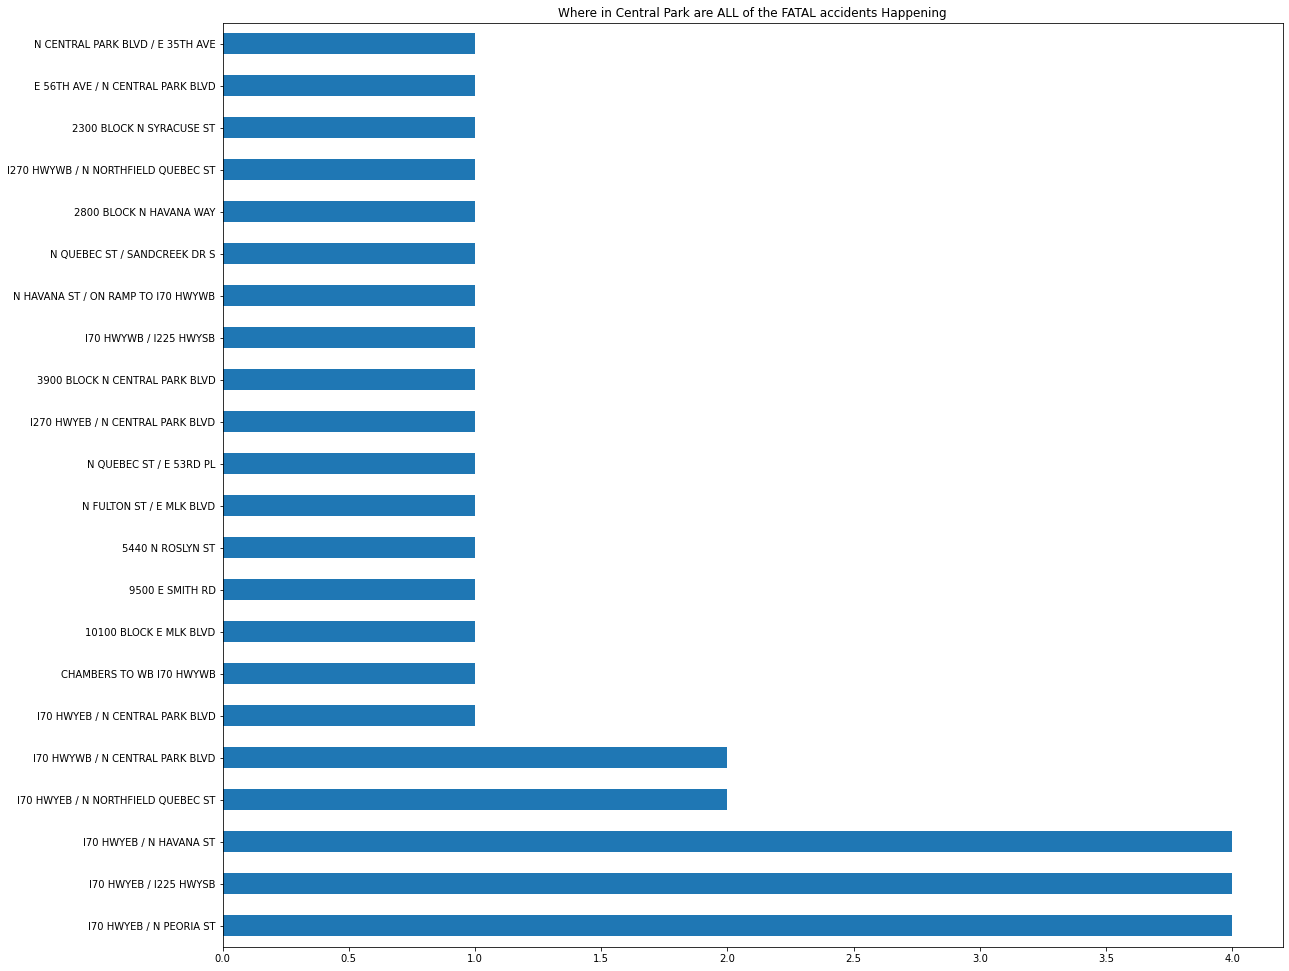

In [32]:
plt.rcParams.update({'figure.figsize': (19, 17.0)})
fatal_accidents['incident_address'][fatal_accidents['neighborhood_id'] == 'Central Park'].value_counts()[:45].plot(kind='barh')
plt.title('Where in Central Park are ALL of the FATAL accidents Happening')

## The  top spots for traffic fatalities are also on I-70

Text(0.5, 1.0, 'Where in Central Park are ALL of the FATAL PEDESTRIAN accidents Happening')

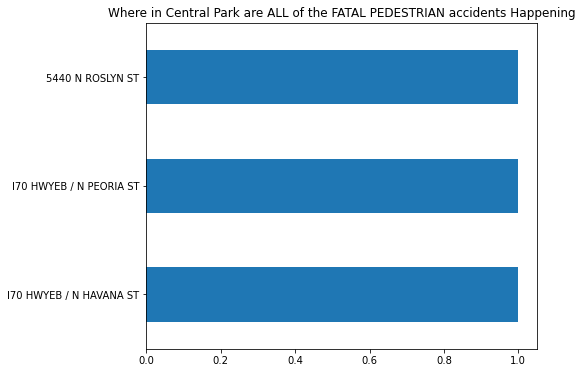

In [33]:
plt.rcParams.update({'figure.figsize': (7, 6.0)})
cond1 = fatal_accidents['neighborhood_id'] == 'Central Park'
cond2 = fatal_accidents['pedestrian_ind'] > 0
fatal_accidents['incident_address'][cond1 & cond2].value_counts()[:5].plot(kind='barh')
plt.title('Where in Central Park are ALL of the FATAL PEDESTRIAN accidents Happening')

## 2/3 of Fatalities involving pedestrians occur at the intersections with the Freeway.

In [34]:
traffic_accidents2['incident_address'].fillna('unknown', inplace = True)

condition_1 = traffic_accidents2['incident_address'].str.contains("HWY")

condition_2 = traffic_accidents2['neighborhood_id'] == 'Central Park'

highway_accidents_cp = traffic_accidents2['offense_id'][condition_1 & condition_2].count()
non_highway_accidents_cp = traffic_accidents2['offense_id'][condition_1 & ~condition_2].count()
non_highway_accidents_cp

31313

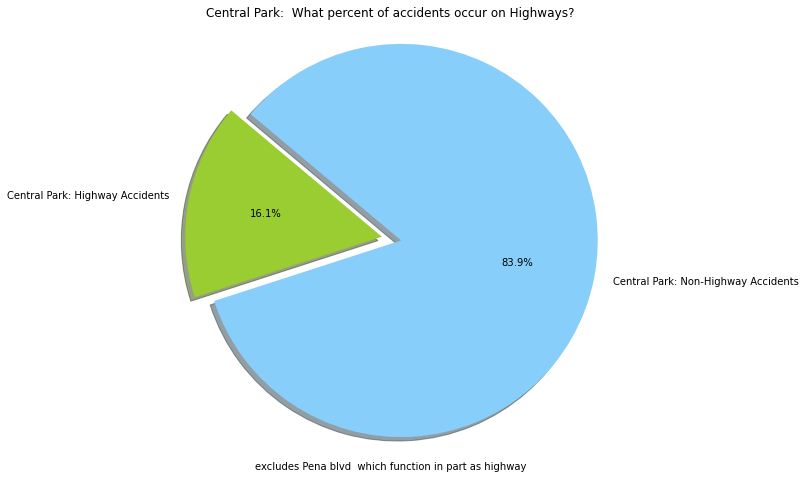

In [35]:
labels = 'Central Park: Highway Accidents', 'Central Park: Non-Highway Accidents'
sizes = [highway_accidents_cp, non_highway_accidents_cp]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.rcParams.update({'figure.figsize': (10, 8.0)})
plt.pie(sizes,  explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Central Park:  What percent of accidents occur on Highways?")
plt.xlabel("excludes Pena blvd  which function in part as highway")
plt.axis('equal')
plt.show()

In [36]:
condition_1 = fatal_accidents['incident_address'].str.contains("HWY")

condition_2 = fatal_accidents['neighborhood_id'] == 'Central Park'

highway_fatalities_cp = fatal_accidents['FATALITIES'][condition_1 & condition_2].sum()
non_highway_fatalities_cp = fatal_accidents['FATALITIES'][condition_1 & ~condition_2].sum()
highway_fatalities_cp

23.0

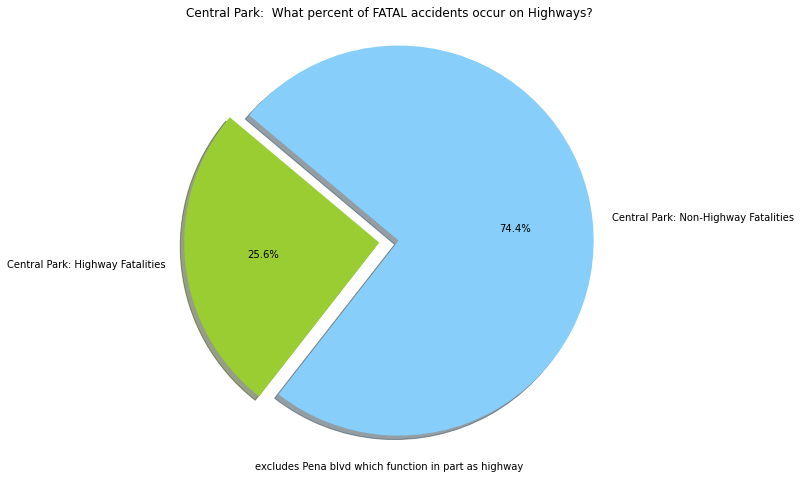

In [37]:
labels = 'Central Park: Highway Fatalities', 'Central Park: Non-Highway Fatalities'
sizes = [highway_fatalities_cp, non_highway_fatalities_cp]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.rcParams.update({'figure.figsize': (10, 8.0)})
plt.pie(sizes,  explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Central Park:  What percent of FATAL accidents occur on Highways?")
plt.xlabel("excludes Pena blvd which function in part as highway")
plt.axis('equal')
plt.show()

##  Considering only ONE road in the whole neighborhood is a Highway, this is a huge percentage of accidents occuring on this ONE road.  


##  Recommendation:  Remove this particular road and you can eliminate 25% of traffic deaths in Central Park. 

In [38]:
## How does this compare to the city as a whole.

In [39]:
highway_accidents = traffic_accidents2['offense_id'][traffic_accidents2['incident_address'].str.contains("HWY")].count()
non_highway_accidents = traffic_accidents2['offense_id'][~traffic_accidents2['incident_address'].str.contains("HWY")].count()
non_highway_accidents

176607

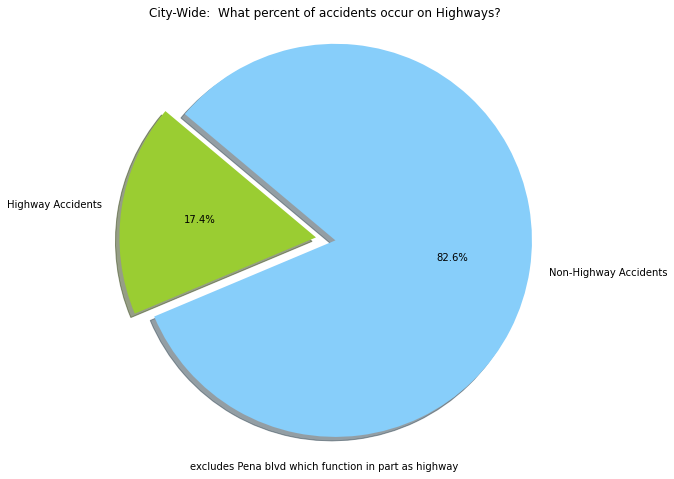

In [40]:
labels = 'Highway Accidents', 'Non-Highway Accidents'
sizes = [highway_accidents, non_highway_accidents]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.rcParams.update({'figure.figsize': (10, 8.0)})
plt.pie(sizes,  explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("City-Wide:  What percent of accidents occur on Highways?")
plt.xlabel("excludes Pena blvd which function in part as highway")
plt.axis('equal')
plt.show()

In [41]:
highway_fatalities = traffic_accidents2['FATALITIES'][traffic_accidents2['incident_address'].str.contains("HWY")].sum()
non_highway_fatalities = traffic_accidents2['FATALITIES'][~traffic_accidents2['incident_address'].str.contains("HWY")].sum()
non_highway_fatalities

413.0

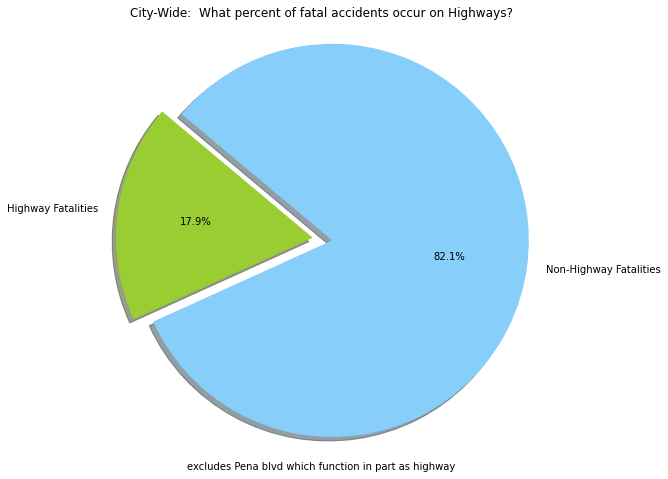

In [42]:
labels = 'Highway Fatalities', 'Non-Highway Fatalities'
sizes = [highway_fatalities, non_highway_fatalities]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.rcParams.update({'figure.figsize': (10, 8.0)})
plt.pie(sizes,  explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("City-Wide:  What percent of fatal accidents occur on Highways?")
plt.xlabel("excludes Pena blvd which function in part as highway")
plt.axis('equal')
plt.show()

## Basically we see that in Central Park, approximately 25.6% of traffic fatalities occur on the highway wherease City-wide that percentage is much lower at 17.9%

## So what if there was no highway?  Lets take a look at what our data would look like without accidents that took place on the highway.

In [43]:
highway = traffic_accidents2[traffic_accidents2['incident_address'].str.contains("HWY")]
non_highway = traffic_accidents2[~traffic_accidents2['incident_address'].str.contains("HWY")]

Text(0.5, 1.0, 'EXCLUDING HIGHWAY:  Total Number of Accidents by Neighborhood')

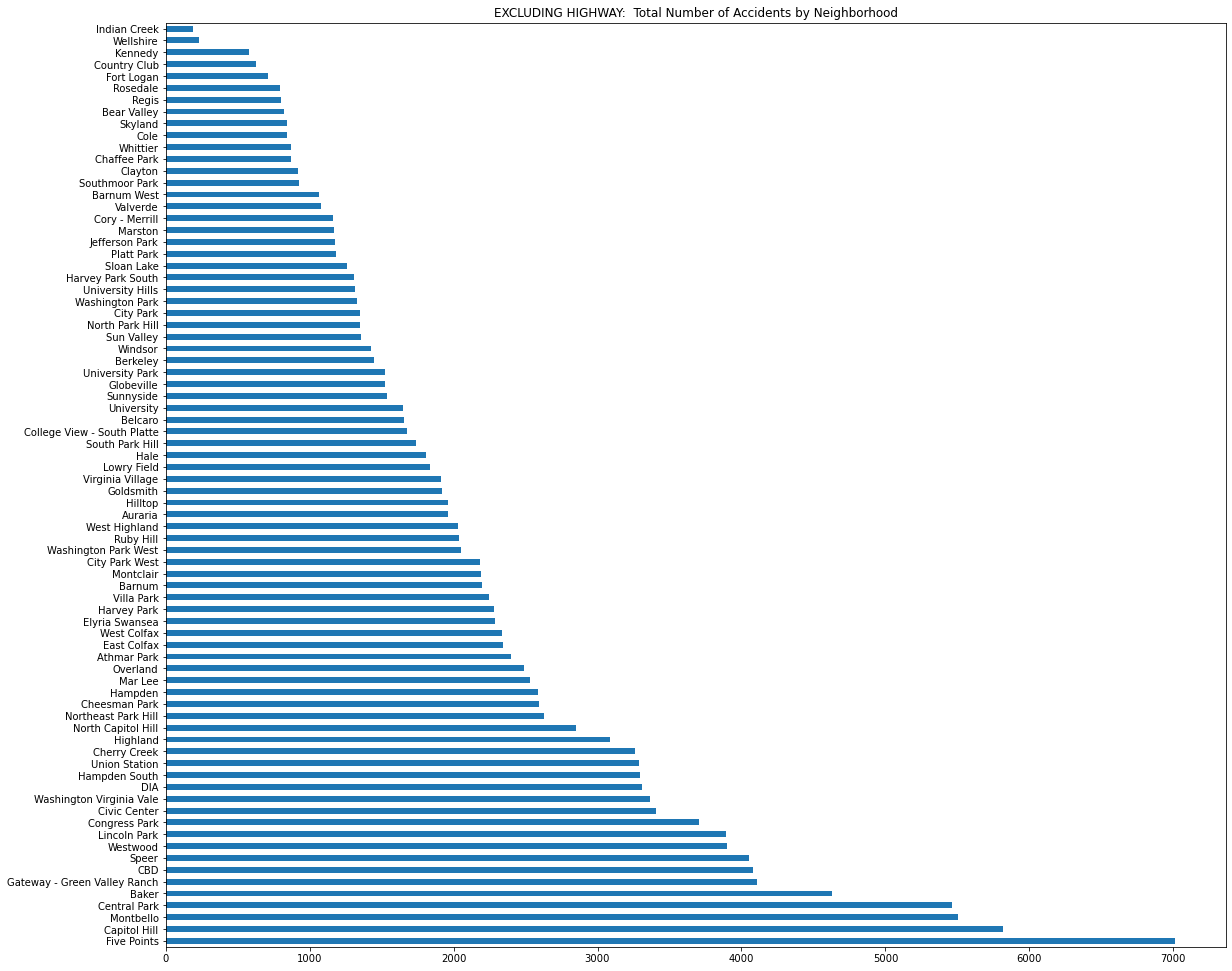

In [44]:
plt.rcParams.update({'figure.figsize': (19, 17.0)})
non_highway['neighborhood_id'].value_counts().plot(kind='barh')
plt.title('EXCLUDING HIGHWAY:  Total Number of Accidents by Neighborhood')

In [45]:
highway_fatal = fatal_accidents[fatal_accidents['incident_address'].str.contains("HWY")]
non_highway_fatal = fatal_accidents[~fatal_accidents['incident_address'].str.contains("HWY")]

Text(0.5, 1.0, 'EXCLUDING HIGHWAY:  Total Number of FATAL Accidents by Neighborhood')

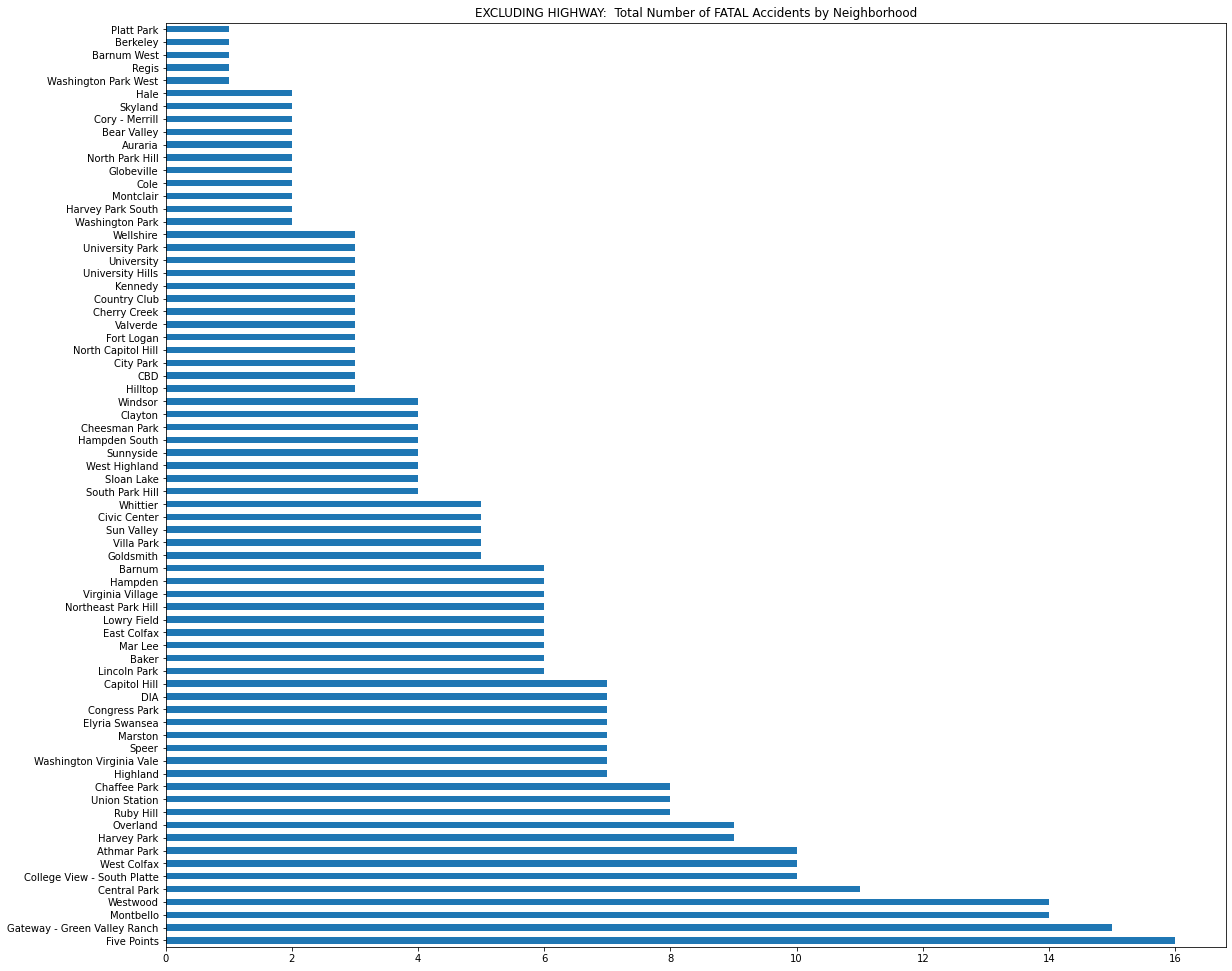

In [46]:
plt.rcParams.update({'figure.figsize': (19, 17.0)})
non_highway_fatal['neighborhood_id'].value_counts().plot(kind='barh')
plt.title('EXCLUDING HIGHWAY:  Total Number of FATAL Accidents by Neighborhood')

###  Without the Highway accidents and fatalities the neighborhood of Central Park is no longer really an outlier.  It is still towards the top of the heap when it comes to accidents and fatalities but that seems reasonable since it is the largest neighborhood in Denver.

###  Conclusion:  For the most part two highways go through Denver, (I-25 and I-70)  Very few roads play host to 17% of Traffic Fatalities in the City.  Please be EXTRA careful when you get on to the highway!!!

In [47]:
#highways = traffic_accidents2[traffic_accidents2['incident_address'].str.contains("HWY")]
#pd.options.display.max_rows = None
#print(highways['incident_address'].value_counts())

#  Step 8: What about Bicyclists and Pedestrians?

Text(0.5, 1.0, 'Total Number of FATAL Accidents involving Bicycles by Neighborhood')

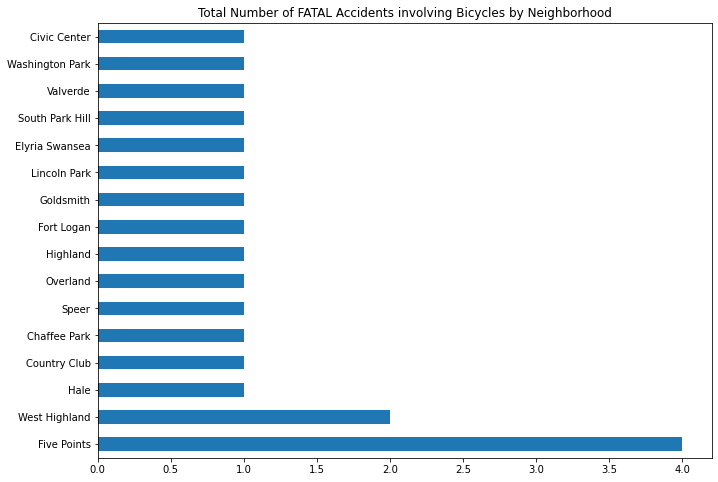

In [48]:
plt.rcParams.update({'figure.figsize': (11, 8.0)})
fatal_accidents['neighborhood_id'][fatal_accidents['bicycle_ind'] > 0].value_counts().plot(kind='barh')
plt.title('Total Number of FATAL Accidents involving Bicycles by Neighborhood')

In [49]:
#  just to confirm there were no fatal bicycle crashes in Central Park
cond2 = fatal_accidents[fatal_accidents['bicycle_ind'] > 0]
cond2[cond2['neighborhood_id']  == 'Central Park']

,offense_id,top_traffic_accident_offense,reported_date,incident_address,precinct_id,neighborhood_id,bicycle_ind,pedestrian_ind,HARMFUL_EVENT_SEQ_1,HARMFUL_EVENT_SEQ_2,...,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,month,year


Text(0.5, 1.0, 'Total Number of FATAL Accidents involving Pedestrians by Neighborhood')

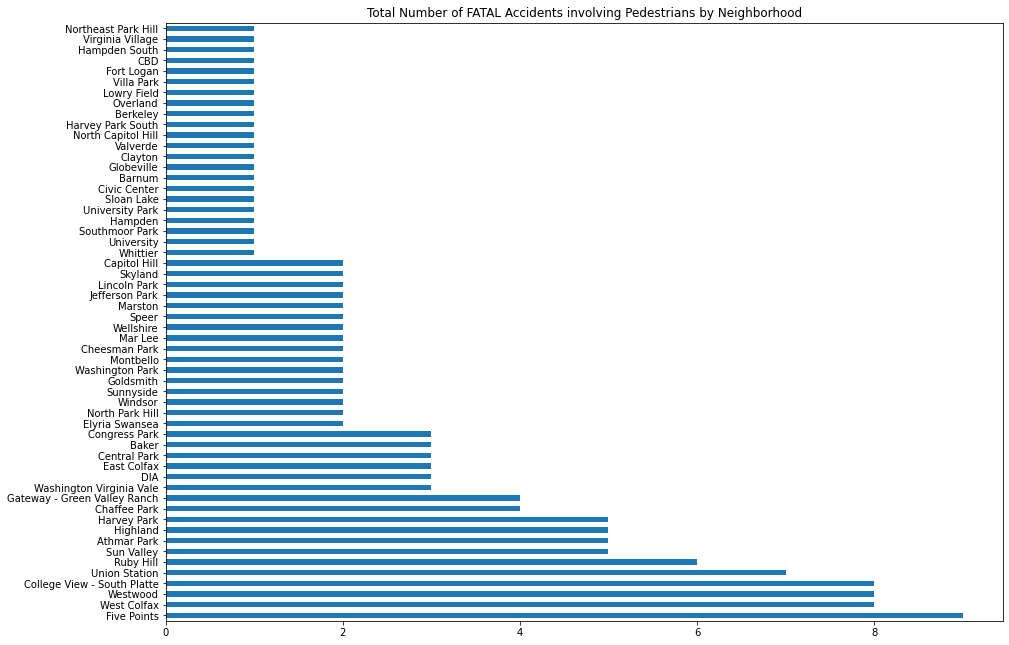

In [50]:
plt.rcParams.update({'figure.figsize': (15, 11.0)})
fatal_accidents['neighborhood_id'][fatal_accidents['pedestrian_ind'] > 0].value_counts().plot(kind='barh')
plt.title('Total Number of FATAL Accidents involving Pedestrians by Neighborhood')

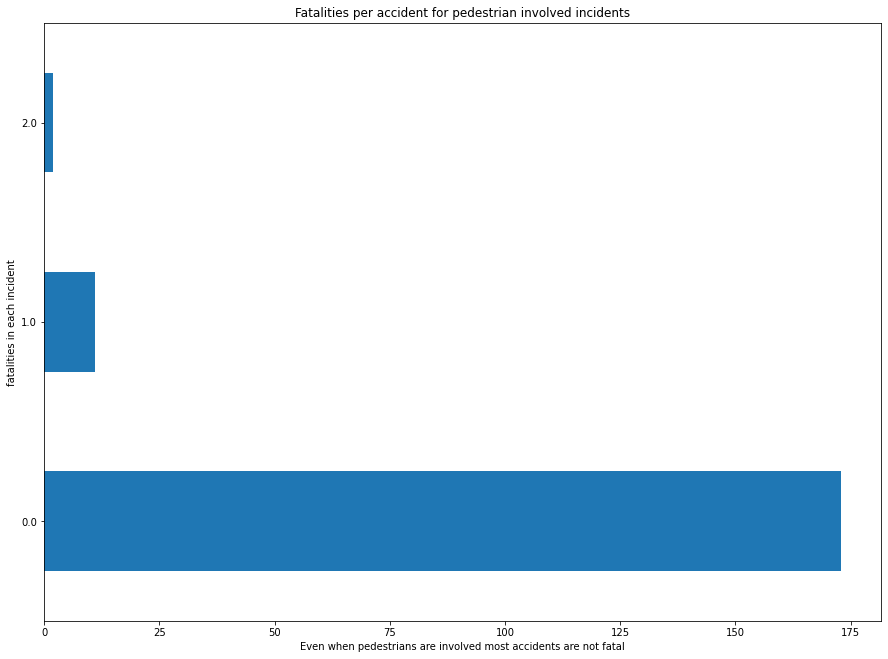

In [51]:
traffic_accidents2['FATALITIES'][traffic_accidents2['pedestrian_ind'] > 1].value_counts().plot(kind = 'barh')
plt.title("Fatalities per accident for pedestrian involved incidents")
plt.ylabel("fatalities in each incident")
plt.xlabel("Even when pedestrians are involved most accidents are not fatal")
plt.show()

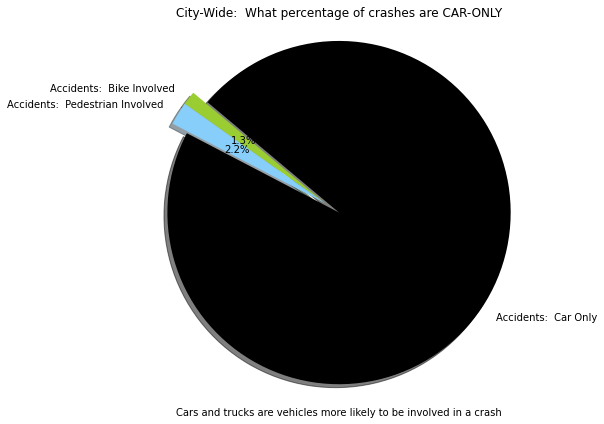

In [52]:
bike_involved  = traffic_accidents2[traffic_accidents2['bicycle_ind'] > 0]
ped_involved = traffic_accidents2[traffic_accidents2['pedestrian_ind'] > 0]
no_ped = traffic_accidents2[traffic_accidents2['pedestrian_ind'] == 0]
car_only = no_ped[no_ped['bicycle_ind']== 0]

plt.rcParams.update({'figure.figsize': (9, 7.0)})
labels = 'Accidents:  Bike Involved', 'Accidents:  Pedestrian Involved', 'Accidents:  Car Only'
sizes = [bike_involved['offense_id'].count(), ped_involved['offense_id'].count(), car_only['offense_id'].count()]
colors = ['yellowgreen', 'lightskyblue', 'black']
explode = (0, 0, 0.1)  # explode 3rd slice

# Plot
plt.pie(sizes,  explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("City-Wide:  What percentage of crashes are CAR-ONLY")
plt.xlabel("Cars and trucks are vehicles more likely to be involved in a crash")
plt.axis('equal')
plt.show()

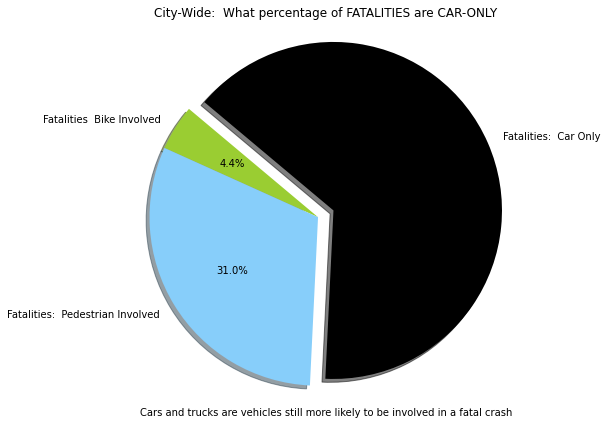

In [53]:
bike_involved  = fatal_accidents[fatal_accidents['bicycle_ind'] > 0]
ped_involved = fatal_accidents[fatal_accidents['pedestrian_ind'] > 0]
no_ped = fatal_accidents[fatal_accidents['pedestrian_ind'] == 0]
car_only = no_ped[no_ped['bicycle_ind']== 0]

plt.rcParams.update({'figure.figsize': (9, 7.0)})
labels = 'Fatalities  Bike Involved', 'Fatalities:  Pedestrian Involved', 'Fatalities:  Car Only'
sizes = [bike_involved['FATALITIES'].count(), ped_involved['FATALITIES'].count(), car_only['FATALITIES'].count()]
colors = ['yellowgreen', 'lightskyblue', 'black']
explode = (0, 0, 0.1)  # explode 3rd slice

# Plot
plt.pie(sizes,  explode = explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("City-Wide:  What percentage of FATALITIES are CAR-ONLY")
plt.xlabel("Cars and trucks are vehicles still more likely to be involved in a fatal crash")
plt.axis('equal')
plt.show()

##  Only a small percent of total traffic accidents involve bicyclists or pedestrians.  However bicyclists and pedestrians are disproportionately represented in FATAL crashes.

# Conclusion:  

####  * Be careful after dark
####  * Be careful on the highway
####  * Dont drive aggressively
####  * Dont drive when intoxicated
####  * The stakes are higher as a pedestrian or cyclist so use extra caution

# Next Steps:

####  * See if we can figure out why so many accidents and fatalities occur in Five Points
####  * Comparison with other cities
####  * Bring in population data to compare number of deaths / accidents per capita.